In [43]:
from datetime import datetime
import os
import imageio

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import xarray as xr
from dask.distributed import Client
import dask

dask.config.set(temporary_directory='/data/pacific/rwegener/')

In [70]:
client = Client()

In [60]:
filepath = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/noaa-coastwatch-geopolar-sst-feedstock/noaa-coastwatch-geopolar-sst.zarr'
geopolar = xr.open_zarr(filepath)
geopolar = geopolar.analysed_sst

In [72]:
monthly_means = geopolar.sel(lat=slice(32, 53), lon=slice(-79, -42)).groupby('time.month').mean('time')

In [73]:
# runtime: 13 minutes (almost exactly)
monthly_means = monthly_means.compute()

In [ ]:
# not needed anymore, but I was proud of it so I kept it
months= pd.date_range('01-01-2000', '12-01-2000', freq='M')
paths = [os.path.join('../data/gulfstream_month_mean', f'gulfstream_monthly_mean_{m}.nc') for m in months.strftime('%m')]

In [114]:
monthly_means

<xarray.DataArray 'analysed_sst' (month: 12, lat: 420, lon: 740)>
array([[[295.83408, 295.97064, 296.09113, ..., 293.57278, 293.57047,
         293.56924],
        [295.55426, 295.69223, 295.81635, ..., 293.545  , 293.54233,
         293.5403 ],
        [295.2999 , 295.4378 , 295.56244, ..., 293.51718, 293.51492,
         293.51236],
        ...,
        [271.37393, 271.3758 , 271.37848, ..., 279.18982, 279.17465,
         279.15836],
        [271.37167, 271.37326, 271.37622, ..., 279.0867 , 279.0727 ,
         279.05817],
        [271.36935,       nan,       nan, ..., 278.98764, 278.97473,
         278.9613 ]],

       [[295.15094, 295.28384, 295.40372, ..., 293.0219 , 293.02277,
         293.02377],
        [294.88486, 295.02164, 295.1466 , ..., 292.98907, 292.99063,
         292.9922 ],
        [294.6362 , 294.7748 , 294.90146, ..., 292.9584 , 292.96033,
         292.9619 ],
...
        [276.5891 , 276.57062, 276.55295, ..., 281.3251 , 281.3152 ,
         281.30527],
        [276.5987 , 276.58557, 276.5717 , ..., 281.2519 , 281.24048,
         281.2295 ],
        [276.6036 ,       nan,       nan, ..., 281.1794 , 281.16718,
         281.1549 ]],

       [[297.1969 , 297.2836 , 297.35947, ..., 294.94595, 294.9426 ,
         294.93848],
        [297.02112, 297.1126 , 297.1918 , ..., 294.9167 , 294.9135 ,
         294.90976],
        [296.85233, 296.9475 , 297.02945, ..., 294.88754, 294.88492,
         294.88135],
        ...,
        [272.61597, 272.606  , 272.59656, ..., 280.02298, 280.00488,
         279.98706],
        [272.62457, 272.61624, 272.60526, ..., 279.91675, 279.89835,
         279.8806 ],
        [272.63193,       nan,       nan, ..., 279.81503, 279.79672,
         279.77972]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 32.03 32.08 32.12 32.17 ... 52.83 52.88 52.92 52.97
  * lon      (lon) float32 -78.97 -78.93 -78.88 -78.82 ... -42.12 -42.08 -42.03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Save Dataset

In [122]:
monthly_means.to_dataset().to_netcdf('../data/gulfstream_monthly_mean.nc')

## Roll up to full average

In [124]:
monthly_mean = xr.open_dataset('../data/gulfstream_monthly_mean.nc')

In [125]:
monthly_mean

<xarray.Dataset>
Dimensions:       (lat: 420, lon: 740, month: 12)
Coordinates:
  * lat           (lat) float32 32.03 32.08 32.12 32.17 ... 52.88 52.92 52.97
  * lon           (lon) float32 -78.97 -78.93 -78.88 ... -42.12 -42.08 -42.03
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    analysed_sst  (month, lat, lon) float32 ...

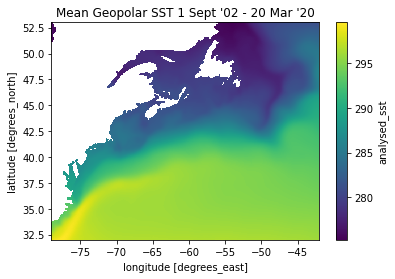

In [126]:
monthly_mean.analysed_sst.mean('month').plot()
plt.title("Mean Geopolar SST 1 Sept '02 - 20 Mar '20")

plt.savefig('../visualization/pretty_pictures/mean_geopolar_sst_fulltimeseries.jpeg')

In [115]:
monthly_mean

<xarray.Dataset>
Dimensions:       (lat: 420, lon: 680, month: 12)
Coordinates:
  * lat           (lat) float32 32.03 32.08 32.12 32.17 ... 52.88 52.92 52.97
  * lon           (lon) float32 -78.97 -78.93 -78.88 ... -45.12 -45.08 -45.03
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    analysed_sst  (month, lat, lon) float32 295.8 296.0 296.1 ... 279.9 279.9

## Creating and saving a gif

In [127]:
testing_it_can_open = xr.open_dataset('../data/gulfstream_monthly_mean.nc')

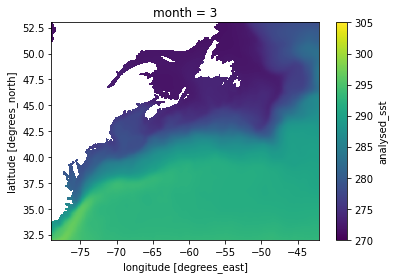

In [128]:
testing_it_can_open.analysed_sst.isel(month=2).plot(vmax=305, vmin=270)

In [129]:
filenames = []
for month in range(12):
    testing_it_can_open.analysed_sst.isel(month=month).plot(vmax=307, vmin=270)
    filename = f'../visualization/scratch/{month}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

In [130]:
with imageio.get_writer('../visualization/pretty_pictures/gulfstream_monthly_climatology.mp4') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)